In [1]:
import tensorflow as tf
import numpy as np
from tabulate import tabulate
import os
from glob import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def get_history_stats(history):
    print(f"Accuracy: {max(history['accuracy']):.{4}f}")
    print(f"Validation accuracy: {max(history['val_accuracy']):.{4}f}")
    print(f"Loss: {min(history['loss']):.{4}f}")
    print(f"Validation loss : {min(history['val_loss']):.{4}f}") 

In [4]:
def model_info(model, verbose=0):
    layer_info = []
    header = ["Number", "Name", "Input_shape", "Output_shape", "Trainable"]
    data = [[]]
    trainable_layers, non_trainable_layers = 0, 0
    trainable_params, non_trainable_params = 0, 0
    for i, layer in enumerate(model.layers):
        layer_name = layer.name
        input_shape = layer.input_shape[1:]
        output_shape = layer.output_shape[1:]
        trainable = layer.trainable
        layer_type = type(layer).__name__
        data.append([i, layer_type if layer_type != "Functional" else layer.name, input_shape, output_shape, trainable])
        layer_params = np.sum([np.prod(p.shape) for p in layer.weights])
        if trainable:
            trainable_params += layer_params
            trainable_layers += 1
        else:
            non_trainable_params += layer_params
            non_trainable_layers += 1
    print("=========================================================")
    print(f"Total params: {int(trainable_params + non_trainable_params):,}")
    print(f"Trainable params: {int(trainable_params):,}")
    print(f"Non-trainable params: {int(non_trainable_params):,}")
    print(f"Total layers: {len(model.layers):,}")
    print(f"Trainable layers: {trainable_layers:,}")
    print(f"Non-trainable params: {non_trainable_layers:,}")
    print("=========================================================")
    if verbose == 1:
        print(tabulate(data, headers=header, colalign="c", tablefmt="github"))

In [5]:
def plot_hist(history):
    plt.figure(figsize=(7, 7))
    plt.subplot(2, 1, 1)
    plt.plot(history["accuracy"], label='Training Accuracy')
    plt.plot(history["val_accuracy"], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([0.5,1])
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(history["loss"], label='Training Loss')
    plt.plot(history["val_loss"], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [6]:
def plot_total_hist(history1, history2, fine_tunning_epoch):
    initial_epochs = fine_tunning_epoch
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(history1["accuracy"] + history2["accuracy"], label='Training Accuracy')
    plt.plot(history1["val_accuracy"] + history2["val_accuracy"], label='Validation Accuracy')
    plt.ylim([0.5, 1])
    plt.plot([initial_epochs-1,initial_epochs-1],
    plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(history1["loss"] + history2["loss"], label='Training Loss')
    plt.plot(history1["val_loss"] + history2["val_loss"], label='Validation Loss')
    plt.ylim([0, 1.0])
    plt.plot([initial_epochs-1,initial_epochs-1],
    plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [9]:
#PATH = "/content/drive/MyDrive/Datasets/data"

#train_dir = os.path.join(PATH, 'train')
#validation_dir = os.path.join(PATH, 'val')
PATH = "/content/drive/MyDrive/Datasets/data2"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

train_dataset = tf.keras.utils.image_dataset_from_directory(PATH,
                                                            subset='training',
                                                            validation_split=0.5,
                                                            seed=42,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(PATH,
                                                                 subset='validation',
                                                                 validation_split=0.5,
                                                                  seed=42,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 3297 files belonging to 2 classes.
Using 1649 files for training.
Found 3297 files belonging to 2 classes.
Using 1648 files for validation.


In [11]:
callbacks_path = "/content/drive/MyDrive/Colab Notebooks/notebooks_fase2/xception_models/"

model_name = callbacks_path + "best_model.h5"
fine_model_name = callbacks_path + "best_model_fine.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_name, 
                                                      monitor="val_accuracy", 
                                                      save_best_only=True, 
                                                      save_weights_only=False, 
                                                      verbose=1,
                                                      mode="max")

fine_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=fine_model_name, 
                                                      monitor="val_accuracy", 
                                                      save_best_only=True, 
                                                      save_weights_only=False, 
                                                      verbose=1,
                                                      mode="max")

In [12]:
base_model = tf.keras.applications.xception.Xception(include_top=False, 
                                                     weights="imagenet", 
                                                     input_shape=IMG_SHAPE)

83683744/83683744 [==============================] - 4s 0us/step


In [13]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [15]:
model_info(base_model)

Total params: 20,861,480
Trainable params: 0
Non-trainable params: 20,861,480
Total layers: 132
Trainable layers: 0
Non-trainable params: 132


In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
])

In [17]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = tf.keras.applications.xception.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
base_learning_rate = 5e-4

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss='binary_crossentropy',
    metrics=["accuracy"]
)

In [20]:
model_info(model, verbose=1)

Total params: 72,242,729
Trainable params: 51,381,249
Non-trainable params: 20,861,480
Total layers: 9
Trainable layers: 8
Non-trainable params: 1
|   Number | Name       | Input_shape   | Output_shape   | Trainable   |
|----------|------------|---------------|----------------|-------------|
|          |            |               |                |             |
| 0        | InputLayer | []            | []             | True        |
| 1        | Sequential | (224, 224, 3) | (224, 224, 3)  | True        |
| 2        | TFOpLambda | (224, 224, 3) | (224, 224, 3)  | True        |
| 3        | TFOpLambda | (224, 224, 3) | (224, 224, 3)  | True        |
| 4        | xception   | (224, 224, 3) | (7, 7, 2048)   | False       |
| 5        | Flatten    | (7, 7, 2048)  | (100352,)      | True        |
| 6        | Dense      | (100352,)     | (512,)         | True        |
| 7        | Dropout    | (512,)        | (512,)         | True        |
| 8        | Dense      | (512,)        | (1,)    

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0     

In [23]:
initial_epochs = 20
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset, 
    callbacks=[model_checkpoint])

Epoch 1/20
52/52 [==============================] - ETA: 0s - loss: 0.4763 - accuracy: 0.8138
Epoch 1: val_accuracy improved from -inf to 0.81978, saving model to /content/drive/MyDrive/Colab Notebooks/notebooks_fase2/xception_models/best_model.h5
52/52 [==============================] - 22s 421ms/step - loss: 0.4763 - accuracy: 0.8138 - val_loss: 0.4175 - val_accuracy: 0.8198
Epoch 2/20
52/52 [==============================] - ETA: 0s - loss: 0.3786 - accuracy: 0.8272
Epoch 2: val_accuracy did not improve from 0.81978
52/52 [==============================] - 15s 287ms/step - loss: 0.3786 - accuracy: 0.8272 - val_loss: 0.4473 - val_accuracy: 0.8113
Epoch 3/20
52/52 [==============================] - ETA: 0s - loss: 0.3393 - accuracy: 0.8514
Epoch 3: val_accuracy did not improve from 0.81978
52/52 [==============================] - 16s 292ms/step - loss: 0.3393 - accuracy: 0.8514 - val_loss: 0.4565 - val_accuracy: 0.8155
Epoch 4/20
52/52 [==============================] - ETA: 0s - loss

#### fine tunning

In [24]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


In [25]:
layers_unfrize = 13

In [26]:
base_model.trainable = True

In [27]:
for i, layer in enumerate(base_model.layers[:-layers_unfrize]):
    layer.trainable = False
for i, layer in enumerate(base_model.layers[-layers_unfrize:]):
        if isinstance(layer, tf.keras.layers.BatchNormalization) or isinstance(layer, tf.keras.layers.AveragePooling2D):
            layer.trainable = False

In [28]:
model_info(base_model, verbose=1)

Total params: 20,861,480
Trainable params: 6,239,128
Non-trainable params: 14,622,352
Total layers: 132
Trainable layers: 9
Non-trainable params: 123
|   Number | Name               | Input_shape           | Output_shape    | Trainable   |
|----------|--------------------|-----------------------|-----------------|-------------|
|          |                    |                       |                 |             |
| 0        | InputLayer         | []                    | []              | False       |
| 1        | Conv2D             | (224, 224, 3)         | (111, 111, 32)  | False       |
| 2        | BatchNormalization | (111, 111, 32)        | (111, 111, 32)  | False       |
| 3        | Activation         | (111, 111, 32)        | (111, 111, 32)  | False       |
| 4        | Conv2D             | (111, 111, 32)        | (109, 109, 64)  | False       |
| 5        | BatchNormalization | (109, 109, 64)        | (109, 109, 64)  | False       |
| 6        | Activation         | (109, 

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(base_learning_rate/10),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0     

In [31]:
fine_tune_epoch = 20
total_epochs = initial_epochs + fine_tune_epoch
fine_history = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[fine_model_checkpoint])

Epoch 20/40
52/52 [==============================] - ETA: 0s - loss: 0.2355 - accuracy: 0.9042
Epoch 20: val_accuracy improved from -inf to 0.83070, saving model to /content/drive/MyDrive/Colab Notebooks/notebooks_fase2/xception_models/best_model_fine.h5
52/52 [==============================] - 31s 413ms/step - loss: 0.2355 - accuracy: 0.9042 - val_loss: 0.4079 - val_accuracy: 0.8307
Epoch 21/40
52/52 [==============================] - ETA: 0s - loss: 0.2086 - accuracy: 0.9151
Epoch 21: val_accuracy improved from 0.83070 to 0.84163, saving model to /content/drive/MyDrive/Colab Notebooks/notebooks_fase2/xception_models/best_model_fine.h5
52/52 [==============================] - 27s 507ms/step - loss: 0.2086 - accuracy: 0.9151 - val_loss: 0.4113 - val_accuracy: 0.8416
Epoch 22/40
52/52 [==============================] - ETA: 0s - loss: 0.1913 - accuracy: 0.9175
Epoch 22: val_accuracy improved from 0.84163 to 0.85012, saving model to /content/drive/MyDrive/Colab Notebooks/notebooks_fase2/

In [32]:
print(history.history)

{'loss': [0.4763111174106598, 0.37859585881233215, 0.3393220007419586, 0.3586212694644928, 0.33626848459243774, 0.3081000745296478, 0.32719266414642334, 0.2759045362472534, 0.2634722888469696, 0.2644106149673462, 0.27643436193466187, 0.27165696024894714, 0.2507374584674835, 0.28449416160583496, 0.2542426288127899, 0.24562400579452515, 0.2405904084444046, 0.25056883692741394, 0.24181225895881653, 0.23117588460445404], 'accuracy': [0.8138265609741211, 0.8271679878234863, 0.8514251112937927, 0.8465737104415894, 0.8508186936378479, 0.8532443642616272, 0.8702243566513062, 0.878714382648468, 0.8756822347640991, 0.8781079649925232, 0.8750758171081543, 0.8781079649925232, 0.8896300792694092, 0.8853850960731506, 0.8963007926940918, 0.8969072103500366, 0.895694375038147, 0.8938750624656677, 0.8908429145812988, 0.8981200456619263], 'val_loss': [0.41752949357032776, 0.44726791977882385, 0.4564724862575531, 0.3881249725818634, 0.37717241048812866, 0.3794053792953491, 0.3897125720977783, 0.402170807

In [33]:
print(fine_history.history)

{'loss': [0.2354738861322403, 0.20863734185695648, 0.1913023293018341, 0.18310898542404175, 0.18984442949295044, 0.14195430278778076, 0.127018541097641, 0.13747051358222961, 0.1205940842628479, 0.12564826011657715, 0.09614003449678421, 0.10004720091819763, 0.11512084305286407, 0.10210699588060379, 0.09934304654598236, 0.0875515267252922, 0.08614712208509445, 0.08925838023424149, 0.08797946572303772, 0.08144363760948181, 0.07233665138483047], 'accuracy': [0.9041843414306641, 0.9151000380516052, 0.9175257682800293, 0.9314736127853394, 0.918738603591919, 0.940570056438446, 0.9502729177474976, 0.9436022043228149, 0.952092170715332, 0.9466343522071838, 0.9581564664840698, 0.9617950320243835, 0.9587628841400146, 0.9557307362556458, 0.9617950320243835, 0.9721043109893799, 0.9672529101371765, 0.9684657454490662, 0.969072163105011, 0.9654335975646973, 0.9727107286453247], 'val_loss': [0.4079481065273285, 0.4113028049468994, 0.41797083616256714, 0.4273877441883087, 0.358273446559906, 0.394302666

In [37]:
get_history_stats(history.history)

Accuracy: 0.8981
Validation accuracy: 0.8422
Loss: 0.2312
Validation loss : 0.3532


In [38]:
get_history_stats(fine_history.history)

Accuracy: 0.9727
Validation accuracy: 0.8647
Loss: 0.0723
Validation loss : 0.3583


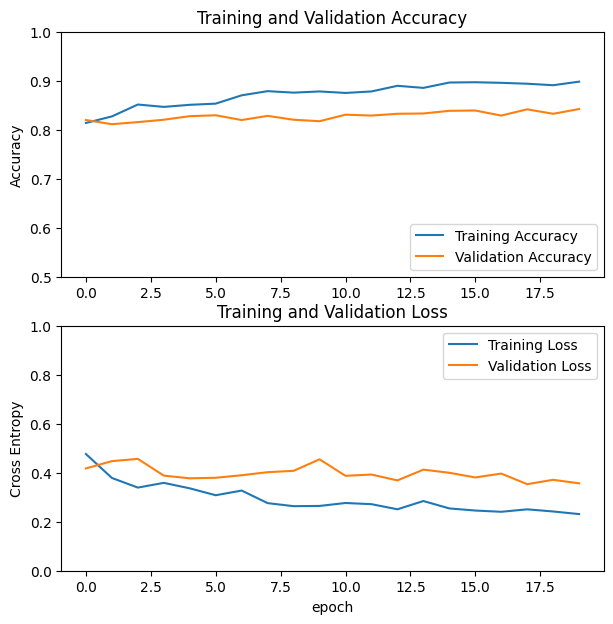

In [34]:
plot_hist(history.history)

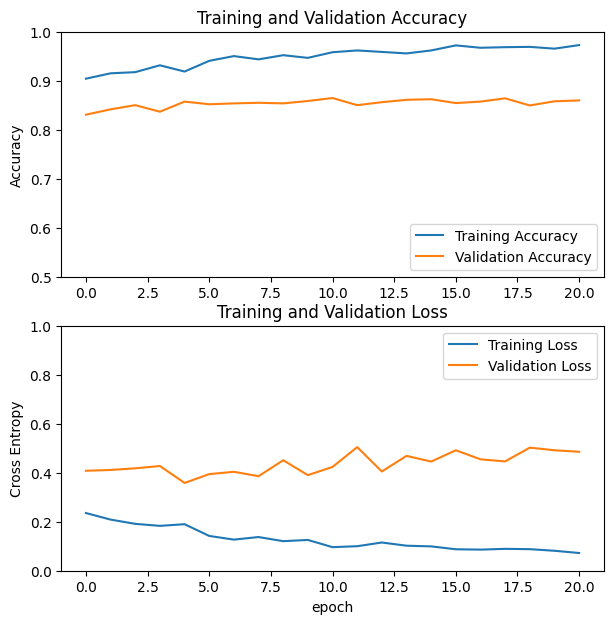

In [35]:
plot_hist(fine_history.history)

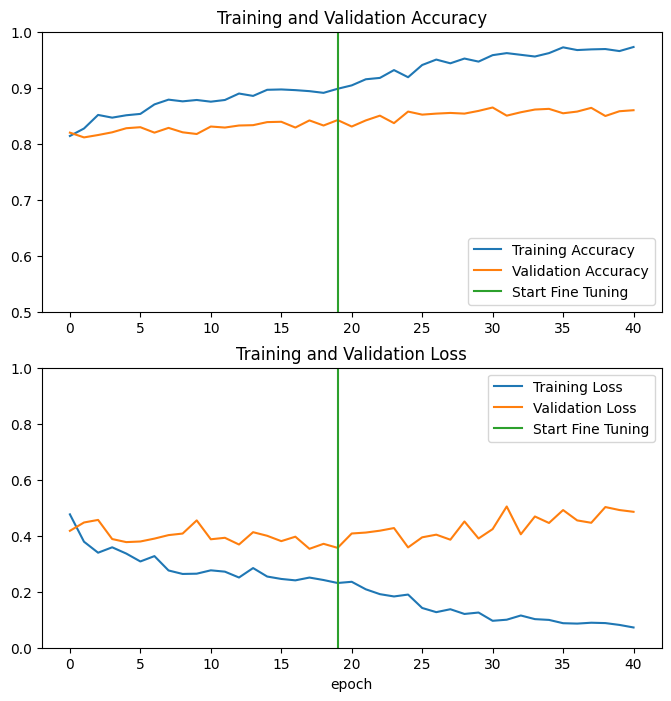

In [36]:
plot_total_hist(history.history, fine_history.history, fine_tune_epoch)